## DeepONet: Learning diffusivity (m) to solution (u) map for the Poisson problem

In [1]:
import sys
import os

import torch
import numpy as np

src_path = "../../src/"
sys.path.append(src_path + 'plotting/')
from field_plot import field_plot 
from plot_loss import plot_loss 

sys.path.append(src_path + 'data/')
from dataMethods import DataProcessor 

sys.path.append(src_path + 'nn/deeponet/')
sys.path.append(src_path + 'nn/mlp/') # need this here so that DeepONet can be imported (it imports MLP)
from torch_deeponet import DeepONet 
import uq 

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# set seed
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
data_folder = '../../../autodl-tmp/data/'
results_dir = data_folder
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

## Load data

In [3]:
num_train = 3500
num_test = 1000

num_inp_fn_points = 2601 # number of grid points for the input function
num_out_fn_points = 2601 # number of evaluations points for the output function
num_Y_components = 1 # scalar field
num_tr_outputs = 100 # number of outputs from the trunk network before they are multiplied
num_br_outputs = 100 # number of outputs from the branch and trunk networks before they are multiplied
out_coordinate_dimension = 2 # domain for output function is 2D


# training hyperparameters
batch_size = 20
epochs = 1000
lr = 1.0e-3
act_fn = torch.relu
 
data_prefix = 'Poisson'

data = DataProcessor(data_folder + data_prefix + '_samples_.npz', num_train, num_test, num_inp_fn_points, num_out_fn_points, num_Y_components)
train_data = {'X_train': data.X_train, 'X_trunk': data.X_trunk, 'Y_train': data.Y_train}
test_data = {'X_train': data.X_test, 'X_trunk': data.X_trunk, 'Y_train': data.Y_test}

print('X_train:',data.X_train.shape)
print('Y_train:',data.Y_train.shape)
print('X_test:',data.X_test.shape)
print('Y_test:',data.Y_test.shape)
print('X_trunk:',data.X_trunk.shape)

X_train: (3500, 2601)
Y_train: (3500, 2601)
X_test: (1000, 2601)
Y_test: (1000, 2601)
X_trunk: (2601, 2)


In [4]:
num_test_shift = 400
# Shifting data sets
data_type=[['no-ood',0.005,0.2,1,0],['ood-1',0.005,0.2,1,0.1],['ood-2',0.005,0.2,1,0.2],\
           ['ood-3',0.005,0.2,1,0.4],['ood-4',0.005,0.2,1,0.8],['ood-5',0.005,0.2,1,1.2], \
            ['ood-6',0.005,0.2,1,-0.2]]
data_shifting = []
data_shifting_data = []
for datatype in data_type:
    data_shifting.append(DataProcessor(data_folder + data_prefix + f'_samples_{datatype[0]}.npz', 100, 400, num_inp_fn_points, num_out_fn_points, num_Y_components))
    data_shifting_data.append({'X_train': data_shifting[-1].X_test, 'X_trunk': data_shifting[-1].X_trunk, 'Y_train': data_shifting[-1].Y_test})

## Create model and train the network

In [5]:
num_layers = 3
num_neurons = 64

model_save_path = results_dir + 'DeepONet/'
model_save_file = model_save_path + 'model.pkl'
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

model = DeepONet(num_layers, num_neurons, act_fn, num_br_outputs, \
                 num_tr_outputs, num_inp_fn_points, \
                 out_coordinate_dimension, num_Y_components,\
                 save_file = model_save_file)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of trainable parameters: {}'.format(trainable_params))

Using device: cuda
Number of trainable parameters: 188041


In [6]:
# save the data and info
data_to_save = data.get_data_to_save()
model_metadata = {  'data': data_to_save, \
                    'num_train': num_train, \
                    'num_test': num_test, \
                    'num_inp_fn_points': num_inp_fn_points, \
                    'num_out_fn_points': num_out_fn_points, \
                    'num_Y_components': num_Y_components, \
                    'num_tr_outputs': num_tr_outputs, \
                    'num_br_outputs': num_br_outputs, \
                    'out_coordinate_dimension': out_coordinate_dimension, \
                    'num_layers': num_layers, \
                    'num_neurons': num_neurons, \
                    'epochs': epochs, \
                    'batch_size': batch_size, \
                    'lr': lr}
# attach it to the model
model.metadata = model_metadata

In [7]:
# Train
model.train(train_data, test_data, batch_size=batch_size, \
            epochs = epochs, lr = lr, \
            save_model = True, save_epoch = 100)

--------------------------------------------------
Starting training with 188041 trainable parameters...
--------------------------------------------------
--------------------------------------------------
Epoch:     1, Train Loss (l2 squared): 4.326e-01, Test Loss (l2 squared): 2.641e-01, Time (sec): 0.511
--------------------------------------------------
--------------------------------------------------
Epoch:   100, Train Loss (l2 squared): 2.265e-02, Test Loss (l2 squared): 2.927e-02, Time (sec): 0.463
--------------------------------------------------
--------------------------------------------------
Model parameters saved at epoch 100
--------------------------------------------------
--------------------------------------------------
Epoch:   200, Train Loss (l2 squared): 1.672e-02, Test Loss (l2 squared): 1.715e-02, Time (sec): 0.360
--------------------------------------------------
--------------------------------------------------
Model parameters saved at epoch 200
----

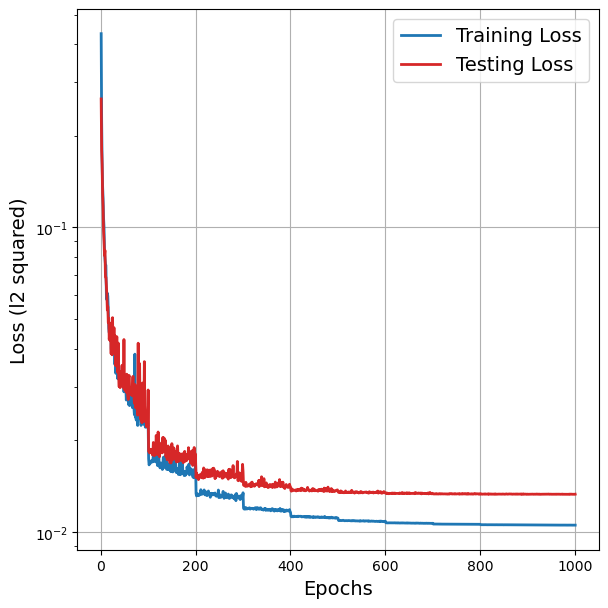

In [8]:
plot_loss( model.train_loss_log[:, 0], \
           model.test_loss_log[:, 0], \
           fs = 14, lw = 2, \
           savefile = results_dir+'loss_his.png', \
           figsize = [6,6])

## Test and plot the output of network

In [9]:
# load the model
model = torch.load(model_save_file, weights_only=False)

sfname = model_save_file.split(os.path.sep)
print('-'*50)
print('Model loaded from: {}'.format(sfname[-2] + '/' + sfname[-1]))
print('\n' + '-'*50)
print('Model metadata:', model.metadata.keys())
print('\n' + '-'*50)
print('Model:', model)

--------------------------------------------------
Model loaded from: DeepONet/model.pkl

--------------------------------------------------
Model metadata: dict_keys(['data', 'num_train', 'num_test', 'num_inp_fn_points', 'num_out_fn_points', 'num_Y_components', 'num_tr_outputs', 'num_br_outputs', 'out_coordinate_dimension', 'num_layers', 'num_neurons', 'epochs', 'batch_size', 'lr'])

--------------------------------------------------
Model: DeepONet(
  (branch_net): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=2601, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=100, bias=True)
    )
  )
  (trunk_net): MLP(
    (layers): ModuleList(
      (0): Linear(in_features=2, out_features=64, bias=True)
      (1): Linear(in_features=64, out_features=64, bias=True)
      (2): Linear(in_features=64, out_features=100, bias=True)
    )
  )
  (bias): ParameterList(  (0): Parameter containing: [to

In [10]:
Y_test = test_data['Y_train']
Y_test_pred = model.predict(test_data['X_train'], test_data['X_trunk']).detach().cpu().numpy()
print('test_out shape: {}, test_pred shape: {}'.format(Y_test.shape, Y_test_pred.shape))
error = np.linalg.norm(Y_test - Y_test_pred, axis = 1)/np.linalg.norm(Y_test, axis = 1)
print('Num tests: {:5d}, Mean Loss (rel l2): {:.3e}, Std Loss (rel l2): {:.3e}'.format(num_test, np.mean(error), np.std(error)))

test_out shape: (1000, 2601), test_pred shape: (1000, 2601)
Num tests:  1000, Mean Loss (rel l2): 1.420e-01, Std Loss (rel l2): 5.056e-02


In [11]:
def apply_dirichlet_bc(u, bc_value, bc_node_ids):
    u[bc_node_ids] = bc_value
    return u

i_plot =   993, error (rel l2): 1.045e-02
i_plot =   859, error (rel l2): 1.557e-02
i_plot =   298, error (rel l2): 9.743e-03
i_plot =   553, error (rel l2): 1.436e-02


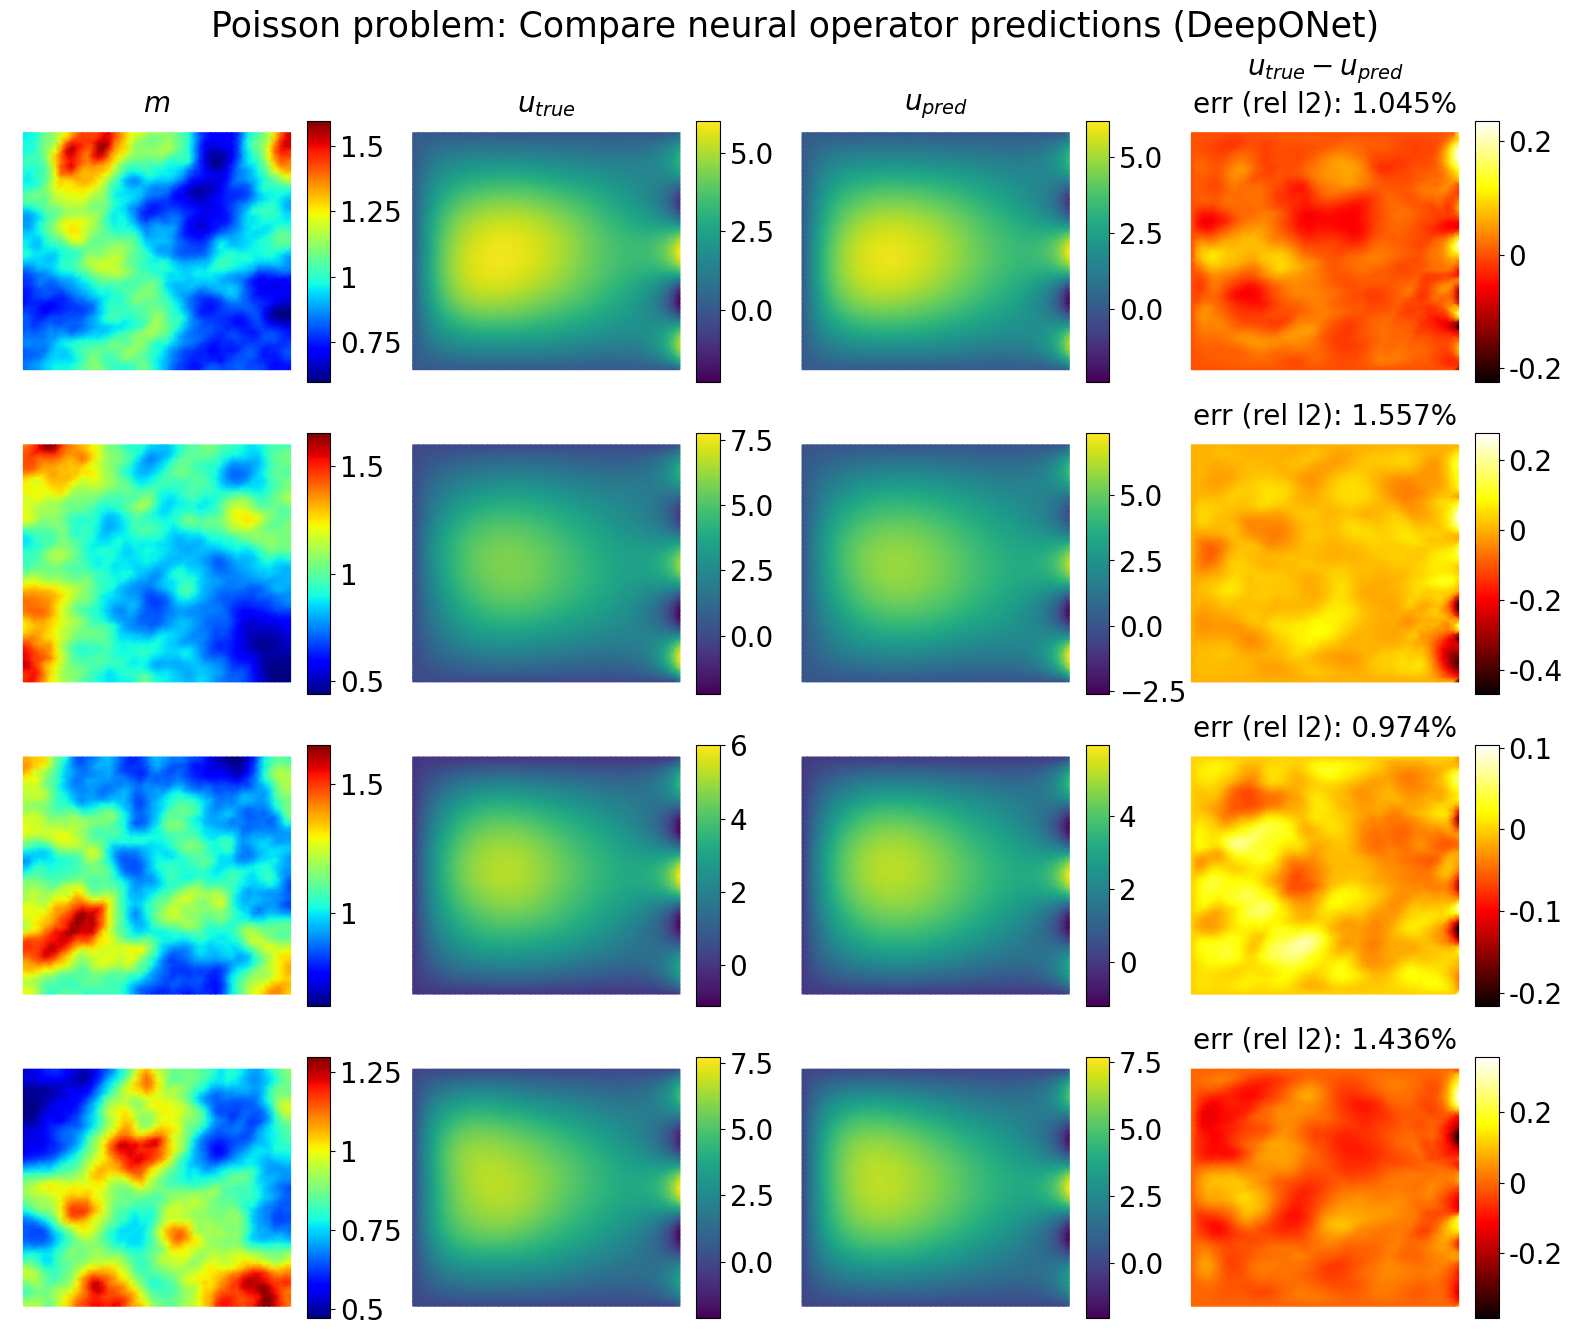

In [12]:
rows, cols = 4, 4
fs = 20
fig, axs = plt.subplots(rows, cols, figsize=(16, 13))

decode = True
apply_dirichlet_bc_flag = True

# row: m, u_true, u_pred, u_diff
u_tags = [r'$m$', r'$u_{true}$', r'$u_{pred}$', r'$u_{true} - u_{pred}$']
cmaps = ['jet', 'viridis', 'viridis', 'hot']

nodes = data.X_trunk 

# randomly choose rows number of samples
i_choices = np.random.choice(num_test, rows, replace=False)

for i in range(rows):
    
    i_plot = i_choices[i]

    i_pred = Y_test_pred[i_plot]
    i_truth = Y_test[i_plot]
    i_m_test = data.X_test[i_plot]
    if decode:
        i_pred = data.decoder_Y(i_pred)
        i_truth = data.decoder_Y(i_truth)
        i_m_test = data.decoder_X(i_m_test)
    if apply_dirichlet_bc_flag:
        i_pred = apply_dirichlet_bc(i_pred, 0.0, data.u_mesh_dirichlet_boundary_nodes)
        # verify for i_truth
        if np.abs(i_truth[data.u_mesh_dirichlet_boundary_nodes]).max() > 1.0e-9:
            print('Warning: Dirichlet BC not applied to i_truth. Err : {}'.format(np.abs(i_truth[data.u_mesh_dirichlet_boundary_nodes]).max()))

            
    i_diff = i_pred - i_truth
    i_diff_norm = np.linalg.norm(i_diff) / np.linalg.norm(i_truth)
    print('i_plot = {:5d}, error (rel l2): {:.3e}'.format(i_plot, i_diff_norm))

    uvec = [i_m_test, i_truth, i_pred, i_diff]
    
    for j in range(cols):
        
        cbar = field_plot(axs[i,j], uvec[j], nodes, cmap = cmaps[j])

        divider = make_axes_locatable(axs[i,j])
        cax = divider.append_axes('right', size='8%', pad=0.03)
        cax.tick_params(labelsize=fs)

        if j == 0 or j == cols - 1:
            # format cbar ticks
            kfmt = lambda x, pos: "{:g}".format(x)
            
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical', format = kfmt)
        else:
            cbar = fig.colorbar(cbar, cax=cax, orientation='vertical')

        if i == 0 and j < cols - 1:
            axs[i,j].set_title(u_tags[j], fontsize=fs)
        
        if j == cols - 1:
            err_str = 'err (rel l2): {:.3f}%'.format(i_diff_norm*100)
            if i == 0:
                err_str = u_tags[j] + '\n' + err_str
            axs[i,j].set_title(err_str, fontsize=fs)

        axs[i,j].axis('off')

fig.tight_layout()
fig.suptitle('Poisson problem: Compare neural operator predictions ({})'.format(model.name), fontsize=1.25*fs, y=1.025)
fig.savefig(results_dir+'neural_operator_prediction_comparison.png',  bbox_inches='tight')
plt.show()


## Uncertainty Quantification Sampling

## HMC

In [13]:
model = torch.load(model_save_file, weights_only=False)
model.to(device)

# Use a subset of test data for  (full dataset may be too slow)
num_hmc_samples_data = 1000  # number of data points to use
hmc_indices = np.random.choice(num_test, num_hmc_samples_data, replace=False)

x_branch_hmc = test_data['X_train'][hmc_indices]
x_trunk_hmc = test_data['X_trunk']
y_hmc = test_data['Y_train'][hmc_indices]

print(f"Using {num_hmc_samples_data} test samples for hmc")
print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")

# Initialize from current model parameters
flat0 = uq.pack_params(model).to(device)
print(f"Initial parameter vector shape: {flat0.shape}")

# Create log probability function
log_prob = uq.make_log_prob_fn(model, x_branch_hmc, x_trunk_hmc, y_hmc, 
                            noise_std=0.05, prior_std=1.0)

# Adaptive hmc settings
hmc_num_samples = 2000
hmc_burn_in = 200          # Increased burn-in for adaptation
hmc_adapt_steps = 150       # Steps to adapt step size
hmc_initial_step_size = 1e-6
hmc_leapfrog_steps = 20
hmc_target_accept = 0.75    # Target acceptance rate (65-80% is optimal)

print(f"\nAdaptive hmc Settings:")
print(f"  num_samples: {hmc_num_samples}")
print(f"  burn_in: {hmc_burn_in}")
print(f"  adapt_steps: {hmc_adapt_steps}")
print(f"  initial_step_size: {hmc_initial_step_size}")
print(f"  leapfrog_steps: {hmc_leapfrog_steps}")
print(f"  target_accept: {hmc_target_accept}")
print()

hmc_samples, acc_rate, final_step_size, step_size_history = uq.hmc_adaptive(
    log_prob, 
    flat0.requires_grad_(True), 
    target_accept=hmc_target_accept,
    initial_step_size=hmc_initial_step_size, 
    leapfrog_steps=hmc_leapfrog_steps, 
    num_samples=hmc_num_samples, 
    burn_in=hmc_burn_in,
    adapt_steps=hmc_adapt_steps
)

print(f"\n{'='*60}")
print(f"Final Results:")
print(f"  Acceptance rate: {acc_rate:.3f} ({acc_rate*100:.1f}%)")
print(f"  Final step size: {final_step_size:.2e}")
print(f"  Collected {len(hmc_samples)} samples")
print(f"{'='*60}") 

torch.save(hmc_samples, model_save_path + 'hmc_samples.pt')


Using 1000 test samples for hmc
Model has 188041 parameters
Initial parameter vector shape: torch.Size([188041])

Adaptive hmc Settings:
  num_samples: 2000
  burn_in: 200
  adapt_steps: 150
  initial_step_size: 1e-06
  leapfrog_steps: 20
  target_accept: 0.75

Starting adaptive HMC with target acceptance rate: 75.00%
Adaptation will run for 150 iterations
Iter   50/2200: accept rate = 0.740, step_size = 9.55e-10, phase = adapting
Iter  100/2200: accept rate = 0.760, step_size = 3.71e-09, phase = adapting
Iter  150/2200: accept rate = 0.753, step_size = 8.34e-10, phase = adapting

>>> Adaptation complete! Final step size: 1.53e-09
>>> Acceptance rate during adaptation: 0.755

Iter  200/2200: accept rate = 0.755, step_size = 1.53e-09, phase = burn-in
Iter  250/2200: accept rate = 0.768, step_size = 1.53e-09, phase = sampling
Iter  300/2200: accept rate = 0.767, step_size = 1.53e-09, phase = sampling
Iter  350/2200: accept rate = 0.763, step_size = 1.53e-09, phase = sampling
Iter  400/22

## Monte-Carlo Dropout

In [14]:
# It suffices to sample when evaluating.

## Laplacian Approximation

In [15]:
# Reload the original model (without dropout) for laplace approximation
model = torch.load(model_save_file, weights_only=False)
model.to(device)

# laplace approximation settings
noise_std_laplace = 0.05  # Assumed observation noise
prior_std_laplace = 1.0   # Prior standard deviation for weights

print(f"\nlaplace Approximation Settings:")
print(f"  Assumed noise std: {noise_std_laplace}")
print(f"  Prior std: {prior_std_laplace}")

# Use a subset of training data for computing the Hessian (full dataet may be too expensive)
num_laplace_data = min(500, num_train)
laplace_indices = np.random.choice(num_train, num_laplace_data, replace=False)

x_branch_laplace = train_data['X_train'][laplace_indices]
x_trunk_laplace = train_data['X_trunk']
y_laplace = train_data['Y_train'][laplace_indices]

print(f"Using {num_laplace_data} training samples for Hessian computation")
print(f"Model has {sum(p.numel() for p in model.parameters())} parameters")

print("\nComputing diagonal Hessian approximation...")
H_diag = uq.compute_diagonal_hessian(
    model, x_branch_laplace, x_trunk_laplace, y_laplace,
    noise_std_laplace, prior_std_laplace, device, batch_size=10, sample_points_per_batch=30
)

# Posterior variance (diagonal approximation)
# σ²_posterior = 1 / H_diag
# IMPORTANT: Clip the posterior variance to prevent excessively large perturbations
# Parameters with very low Hessian (low curvature) would otherwise have huge variance,
# causing the model to produce wildly different outputs.
# We use a maximum posterior std of 0.01 (relative to typical weight magnitudes)
max_posterior_var = 0.01 ** 2  # Maximum variance corresponds to std of 0.01
posterior_var = 1.0 / (H_diag + 1e-8)  # Raw posterior variance
posterior_var = torch.clamp(posterior_var, max=max_posterior_var)  # Clip to prevent huge perturbations

print(f"\nHessian diagonal statistics:")
print(f"  Mean H_diag: {H_diag.mean().item():.4e}")
print(f"  Max H_diag:  {H_diag.max().item():.4e}")
print(f"  Min H_diag:  {H_diag.min().item():.4e}")
print(f"  Mean posterior σ (clipped): {torch.sqrt(posterior_var).mean().item():.4e}")
print(f"  Max posterior σ (clipped):  {torch.sqrt(posterior_var).max().item():.4e}")

# Clean up Hessian computation variables
del x_branch_laplace, x_trunk_laplace, y_laplace
torch.cuda.empty_cache() if torch.cuda.is_available() else None

# ============================================================
# Sample from the laplace posterior
# θ ~ N(θ_MAP, diag(1/H_diag))
# ============================================================
print("\nSampling from laplace posterior...")

num_la_samples = 2000  # Number of posterior samples
theta_map = uq.pack_params(model).to(device)

# Compute posterior std once
posterior_std_vec = torch.sqrt(posterior_var)

# Sample from the posterior
la_samples = []
for i in range(num_la_samples):
    # Sample: θ = θ_MAP + σ_posterior * ε, where ε ~ N(0, I)
    epsilon = torch.randn_like(theta_map)
    theta_sample = theta_map + posterior_std_vec * epsilon
    la_samples.append(theta_sample)
    del epsilon, theta_sample

la_samples = torch.stack(la_samples)
print(f"Generated {num_la_samples} posterior samples")

# Free memory from Hessian computation
del H_diag, posterior_var, posterior_std_vec
torch.cuda.empty_cache() if torch.cuda.is_available() else None
torch.save(la_samples.cpu(), model_save_path + 'la_samples.pt')



laplace Approximation Settings:
  Assumed noise std: 0.05
  Prior std: 1.0
Using 500 training samples for Hessian computation
Model has 188041 parameters

Computing diagonal Hessian approximation...
  Processed 100/500 samples
  Processed 200/500 samples
  Processed 300/500 samples
  Processed 400/500 samples
  Processed 500/500 samples

Hessian diagonal statistics:
  Mean H_diag: 1.6421e+06
  Max H_diag:  3.7301e+09
  Min H_diag:  1.0000e+00
  Mean posterior σ (clipped): 3.6960e-03
  Max posterior σ (clipped):  1.0000e-02

Sampling from laplace posterior...
Generated 2000 posterior samples


## Evaluation metrics

In [6]:
results_id = []
results_shifting = []
std_id = []
std_shifting = []
# load the samples if needed.
hmc_samples = torch.load(model_save_path + 'hmc_samples.pt').to(device)
la_samples = torch.load(model_save_path + 'la_samples.pt').to(device)

In [7]:
std_hmc = []
results_hmc = []
for i in range(-1,7):
    model = torch.load(model_save_file, weights_only=False)
    model.to(device)
    if i==-1:
        std, result = uq.uqevaluation(num_test_shift, test_data, model, 'hmc', hmc_samples=hmc_samples.clone())  # pyright: ignore[reportAttributeAccessIssue]
        std_id.append(std)
        results_id.append(result)
    else:
        std_i, result_i = uq.uqevaluation(num_test_shift, data_shifting_data[i], model, 'hmc', hmc_samples=hmc_samples.clone())  # pyright: ignore[reportAttributeAccessIssue]
        std_hmc.append(std_i)
        results_hmc.append(result_i)
    print(f" Complete {i+2} epoch")
std_shifting.append(np.stack(std_hmc))
results_shifting.append(np.stack(results_hmc))

Evaluating uncertainty on 400 test samples...
Computing posterior predictions...
 Complete 1 epoch
Evaluating uncertainty on 400 test samples...
Computing posterior predictions...
 Complete 2 epoch
Evaluating uncertainty on 400 test samples...
Computing posterior predictions...
 Complete 3 epoch
Evaluating uncertainty on 400 test samples...
Computing posterior predictions...
 Complete 4 epoch
Evaluating uncertainty on 400 test samples...
Computing posterior predictions...
 Complete 5 epoch
Evaluating uncertainty on 400 test samples...
Computing posterior predictions...
 Complete 6 epoch
Evaluating uncertainty on 400 test samples...
Computing posterior predictions...
 Complete 7 epoch
Evaluating uncertainty on 400 test samples...
Computing posterior predictions...
 Complete 8 epoch


In [8]:
std_mcd = []
results_mcd = []
for i in range(-1,7):
    model = torch.load(model_save_file, weights_only=False)
    model.to(device)
    uq.inject_dropout(model)
    torch.nn.Module.train(model)
    for module in model.modules():
        if isinstance(module, torch.nn.Dropout):
            torch.nn.Module.train(module)
    if i==-1:
        std, result = uq.uqevaluation(num_test_shift, test_data, model, 'mcd')
        std_id.append(std)
        results_id.append(result)
    else:
        std_i, result_i = uq.uqevaluation(num_test_shift, data_shifting_data[i], model, 'mcd')
        std_mcd.append(std_i)
        results_mcd.append(result_i)
    print(f" Complete {i+1} epoch")
std_shifting.append(np.stack(std_mcd))
results_shifting.append(np.stack(results_mcd))


Evaluating uncertainty on 400 test samples...
Computing MC Dropout predictions...
 Complete 0 epoch
Evaluating uncertainty on 400 test samples...
Computing MC Dropout predictions...
 Complete 1 epoch
Evaluating uncertainty on 400 test samples...
Computing MC Dropout predictions...
 Complete 2 epoch
Evaluating uncertainty on 400 test samples...
Computing MC Dropout predictions...
 Complete 3 epoch
Evaluating uncertainty on 400 test samples...
Computing MC Dropout predictions...
 Complete 4 epoch
Evaluating uncertainty on 400 test samples...
Computing MC Dropout predictions...
 Complete 5 epoch
Evaluating uncertainty on 400 test samples...
Computing MC Dropout predictions...
 Complete 6 epoch
Evaluating uncertainty on 400 test samples...
Computing MC Dropout predictions...
 Complete 7 epoch


In [9]:
std_la = []
results_la = []
for i in range(-1,7):
    model = torch.load(model_save_file, weights_only=False)
    model.to(device)
    if i==-1:
        std, result = uq.uqevaluation(num_test_shift, test_data, model, 'la', la_samples=la_samples.clone())  # pyright: ignore[reportAttributeAccessIssue]
        std_id.append(std)
        results_id.append(result)
    else:
        std_i, result_i = uq.uqevaluation(num_test_shift, data_shifting_data[i], model, 'la', la_samples=la_samples.clone()) # pyright: ignore[reportAttributeAccessIssue]
        std_la.append(std_i)
        results_la.append(result_i)
    print(f" Complete {i+2} epoch")
std_shifting.append(np.stack(std_la))
results_shifting.append(np.stack(results_la))

Evaluating uncertainty on 400 test samples...
Computing Laplace posterior predictions...
 Complete 1 epoch
Evaluating uncertainty on 400 test samples...
Computing Laplace posterior predictions...
 Complete 2 epoch
Evaluating uncertainty on 400 test samples...
Computing Laplace posterior predictions...
 Complete 3 epoch
Evaluating uncertainty on 400 test samples...
Computing Laplace posterior predictions...
 Complete 4 epoch
Evaluating uncertainty on 400 test samples...
Computing Laplace posterior predictions...
 Complete 5 epoch
Evaluating uncertainty on 400 test samples...
Computing Laplace posterior predictions...
 Complete 6 epoch
Evaluating uncertainty on 400 test samples...
Computing Laplace posterior predictions...
 Complete 7 epoch
Evaluating uncertainty on 400 test samples...
Computing Laplace posterior predictions...
 Complete 8 epoch


In [11]:
# Save UQ results
results_id = np.array(results_id) # method*metric
results_shifting = np.array(results_shifting) # method*datatype*metric
std_id = np.array(std_id) # method*sample
std_shifting = np.array(std_shifting) # method*datatype*sample
np.savez(model_save_path + 'uq_results_deeponet.npz', results_id=results_id, results_shifting=results_shifting, std_id=std_id, std_shifting=std_shifting)

## Assess evaluation metrics

In [12]:
# load data if needed
results_id, results_shifting, std_id, std_shifting = np.load(model_save_path + 'uq_results_deeponet.npz').values()

### ID data performance

In [13]:
uq.comparison_uq(*results_id)

COMPARISON: HMC vs MC Dropout vs Laplace Approximation

Metric                             HMC   MC Dropout      Laplace      Ideal
-------------------------------------------------------------------------------------
RMSE                          0.114786     0.293756     0.116338      Lower
Coverage 1σ (%)                   42.3         99.6         47.2       68.3
Coverage 2σ (%)                   70.9        100.0         76.5       95.4
Coverage 3σ (%)                   85.8        100.0         90.0       99.7
MPIW                            0.2000       2.9192       0.2290      Lower
NLL                             0.5583       0.5589      -0.0747      Lower


### Shifting data performance

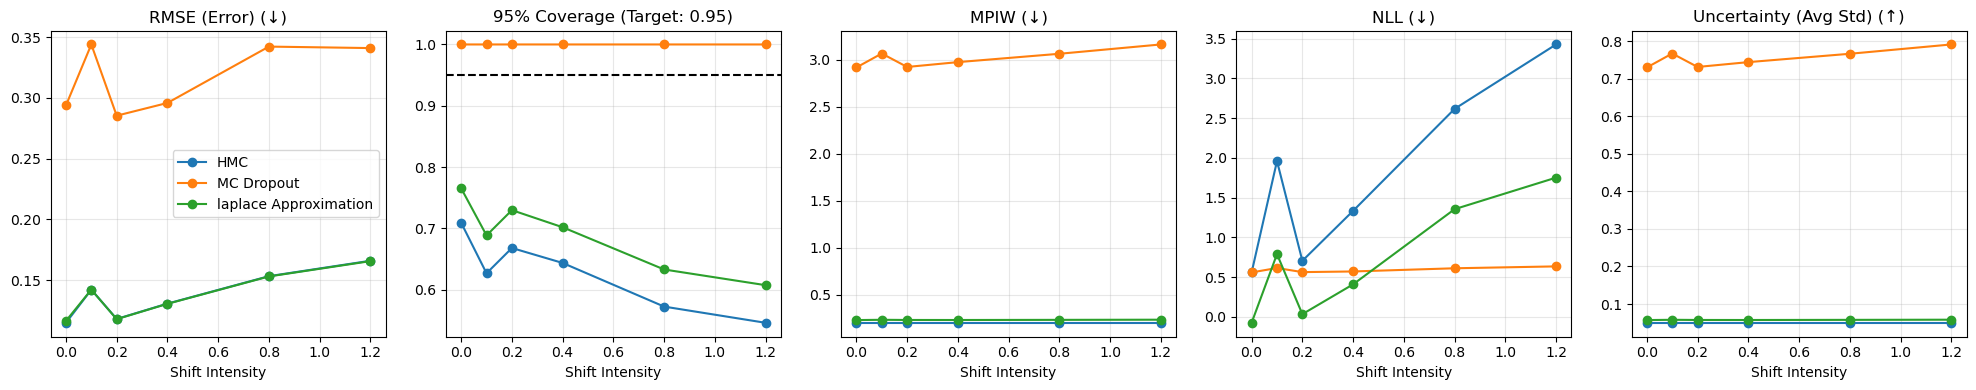

In [14]:
method = ['HMC', 'MC Dropout', 'laplace Approximation']
levels = [0, 0.1, 0.2, 0.4, 0.8, 1.2]
results_id_expanded = np.repeat(results_id[:, np.newaxis, :], repeats=1, axis=1)
results = np.concatenate((results_id_expanded, results_shifting[:,1:,:]), axis=1)
uq.run_regression_shift(method, levels, results)

### Robustness check

In [15]:
uq.comparison_uq(*results_shifting[:,0,:])

COMPARISON: HMC vs MC Dropout vs Laplace Approximation

Metric                             HMC   MC Dropout      Laplace      Ideal
-------------------------------------------------------------------------------------
RMSE                          0.125258     0.333932     0.125289      Lower
Coverage 1σ (%)                   38.4         99.4         43.3       68.3
Coverage 2σ (%)                   66.3        100.0         72.8       95.4
Coverage 3σ (%)                   82.6        100.0         87.9       99.7
MPIW                            0.2000       3.1387       0.2326      Lower
NLL                             1.0611       0.6206       0.1866      Lower


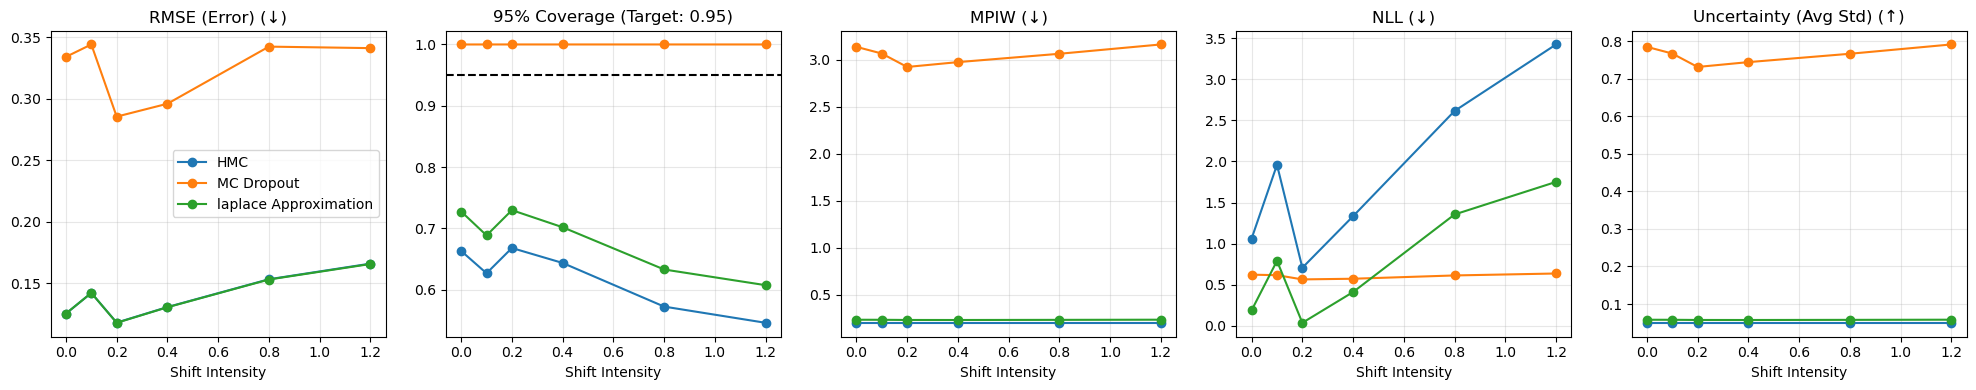

In [16]:
method = ['HMC', 'MC Dropout', 'laplace Approximation']
levels = [0, 0.1, 0.2, 0.4, 0.8, 1.2]
uq.run_regression_shift(method, levels, results_shifting)

## OOD data detection

Method: HMC, Data: 0 -> AUROC: 0.5413
Method: HMC, Data: 0.1 -> AUROC: 0.4955
Method: HMC, Data: 0.2 -> AUROC: 0.5194
Method: HMC, Data: 0.4 -> AUROC: 0.5448
Method: HMC, Data: 0.8 -> AUROC: 0.5606
Method: HMC, Data: 1.2 -> AUROC: 0.5144
Method: MC Dropout, Data: 0 -> AUROC: 0.5386
Method: MC Dropout, Data: 0.1 -> AUROC: 0.5039
Method: MC Dropout, Data: 0.2 -> AUROC: 0.5140
Method: MC Dropout, Data: 0.4 -> AUROC: 0.5368
Method: MC Dropout, Data: 0.8 -> AUROC: 0.5605
Method: MC Dropout, Data: 1.2 -> AUROC: 0.5103
Method: laplace Approximation, Data: 0 -> AUROC: 0.5647
Method: laplace Approximation, Data: 0.1 -> AUROC: 0.5359
Method: laplace Approximation, Data: 0.2 -> AUROC: 0.5208
Method: laplace Approximation, Data: 0.4 -> AUROC: 0.5557
Method: laplace Approximation, Data: 0.8 -> AUROC: 0.5780
Method: laplace Approximation, Data: 1.2 -> AUROC: 0.5253


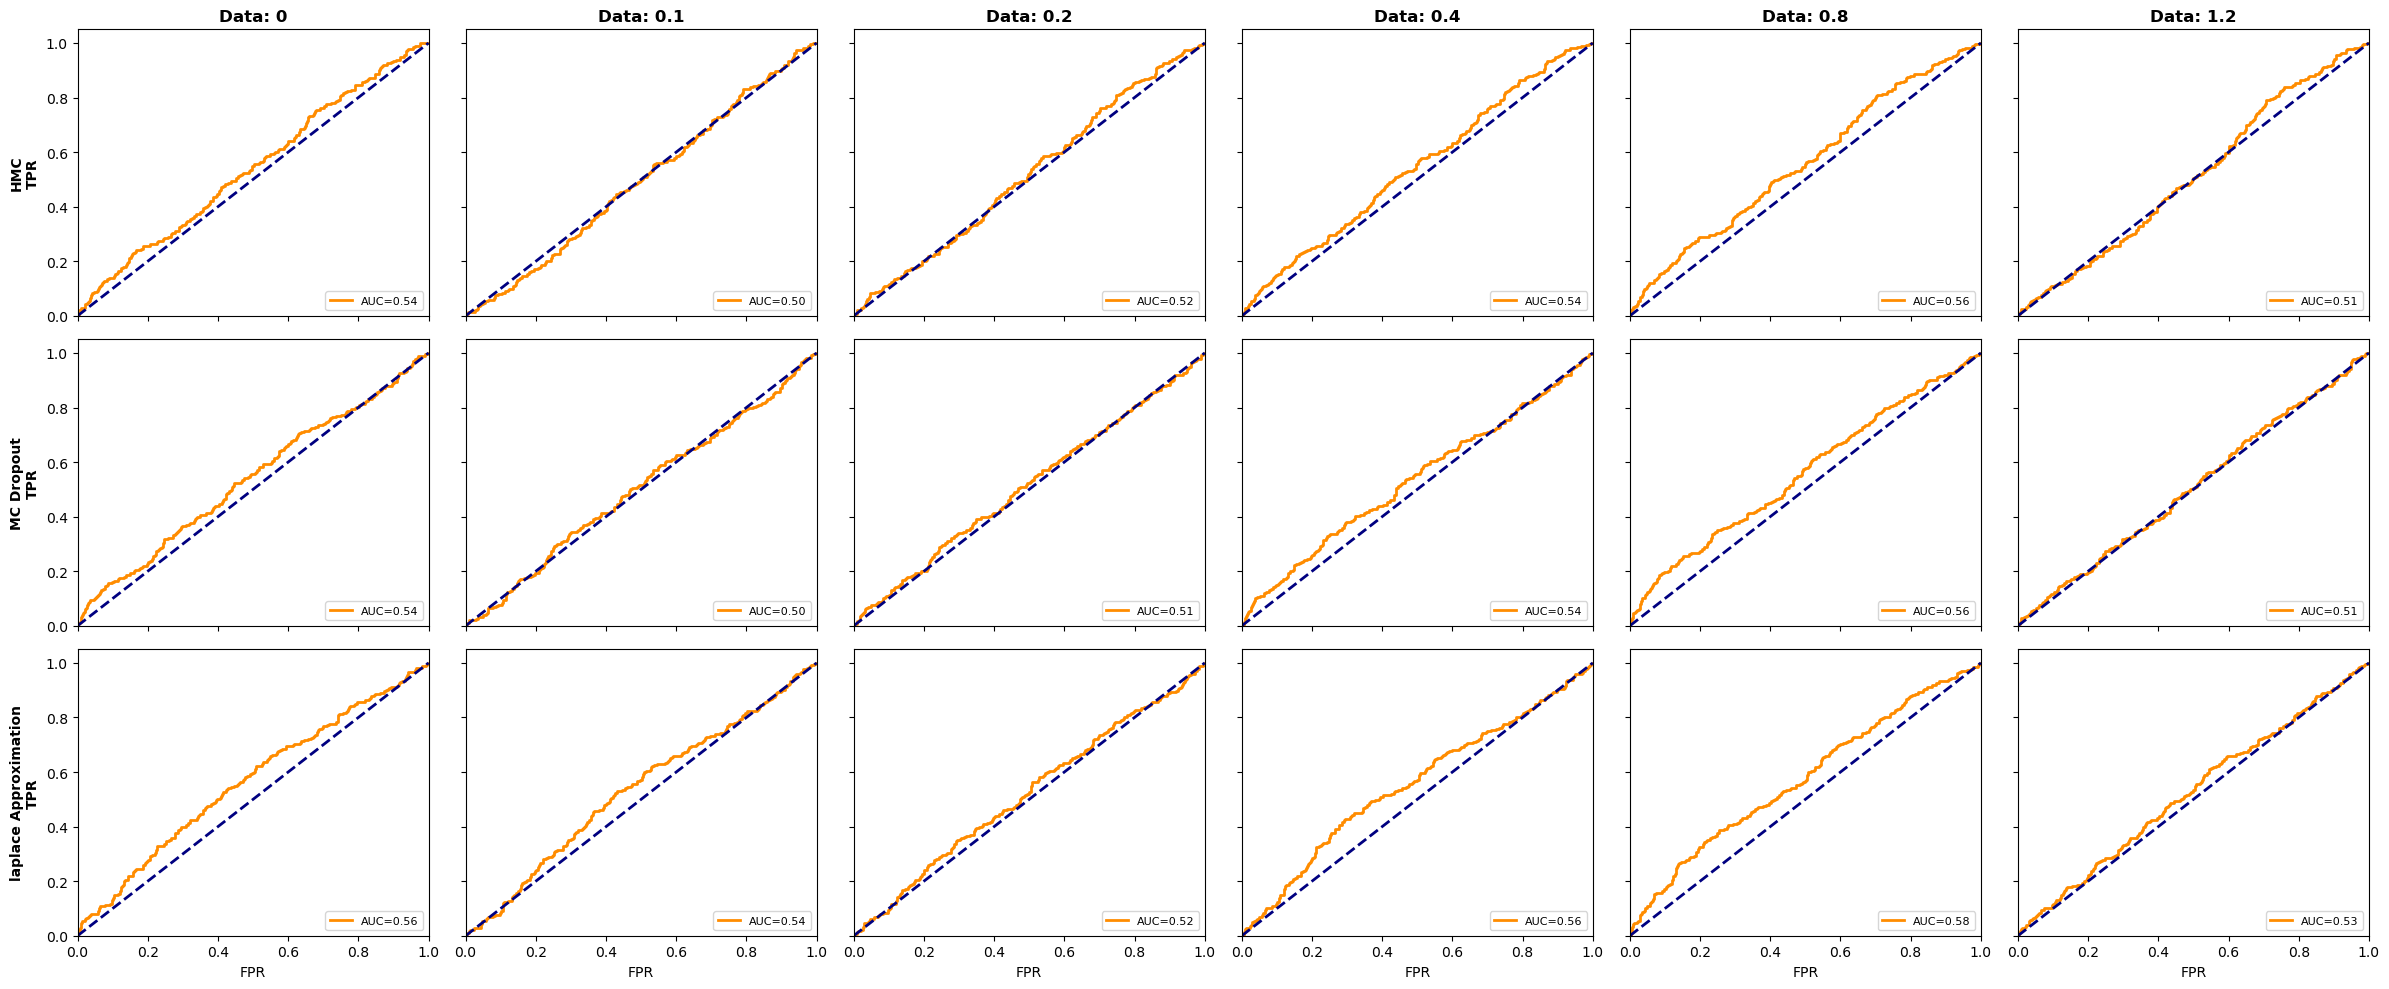

In [ ]:
uq_methods_list = ['HMC', 'MC Dropout', 'laplace Approximation']
datatypes = ['0.1', '0.2', '0.4', '0.8', '1.2', '-0.2']
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24, 10), sharex=True, sharey=True)
for i, uqmethod in enumerate(uq_methods_list):     
    for j, dt in enumerate(datatypes):
        ax = axes[i, j]
        ood = np.concatenate((std_id[i], std_shifting[i][j+1]), axis = 0)
        ood = ood / np.max(ood)
        oods = np.concatenate((np.zeros(std_id[i].shape[0]), np.ones(std_shifting[i][j+1].shape[0])), axis = 0)
        auroc = roc_auc_score(oods, ood)
        fpr, tpr, _ = roc_curve(oods, ood)
        print(f"Method: {uqmethod}, Data: {dt} -> AUROC: {auroc:.4f}")
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC={auroc:.2f}')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        if i == 0:
            ax.set_title(f"Data: {dt}", fontsize=12, fontweight='bold')
        if j == 0:
            ax.set_ylabel(f"{uqmethod}\nTPR", fontsize=10, fontweight='bold')
        else:
            ax.set_ylabel("")
        if i == 2:
            ax.set_xlabel('FPR')
        ax.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()

Method: HMC, Data: 0 -> AUROC: 0.4937
Method: HMC, Data: 0.1 -> AUROC: 0.4472
Method: HMC, Data: 0.2 -> AUROC: 0.4709
Method: HMC, Data: 0.4 -> AUROC: 0.4961
Method: HMC, Data: 0.8 -> AUROC: 0.5126
Method: HMC, Data: 1.2 -> AUROC: 0.4650
Method: MC Dropout, Data: 0 -> AUROC: 0.4809
Method: MC Dropout, Data: 0.1 -> AUROC: 0.4450
Method: MC Dropout, Data: 0.2 -> AUROC: 0.4561
Method: MC Dropout, Data: 0.4 -> AUROC: 0.4795
Method: MC Dropout, Data: 0.8 -> AUROC: 0.5014
Method: MC Dropout, Data: 1.2 -> AUROC: 0.4517
Method: laplace Approximation, Data: 0 -> AUROC: 0.4929
Method: laplace Approximation, Data: 0.1 -> AUROC: 0.4623
Method: laplace Approximation, Data: 0.2 -> AUROC: 0.4497
Method: laplace Approximation, Data: 0.4 -> AUROC: 0.4840
Method: laplace Approximation, Data: 0.8 -> AUROC: 0.5075
Method: laplace Approximation, Data: 1.2 -> AUROC: 0.4530


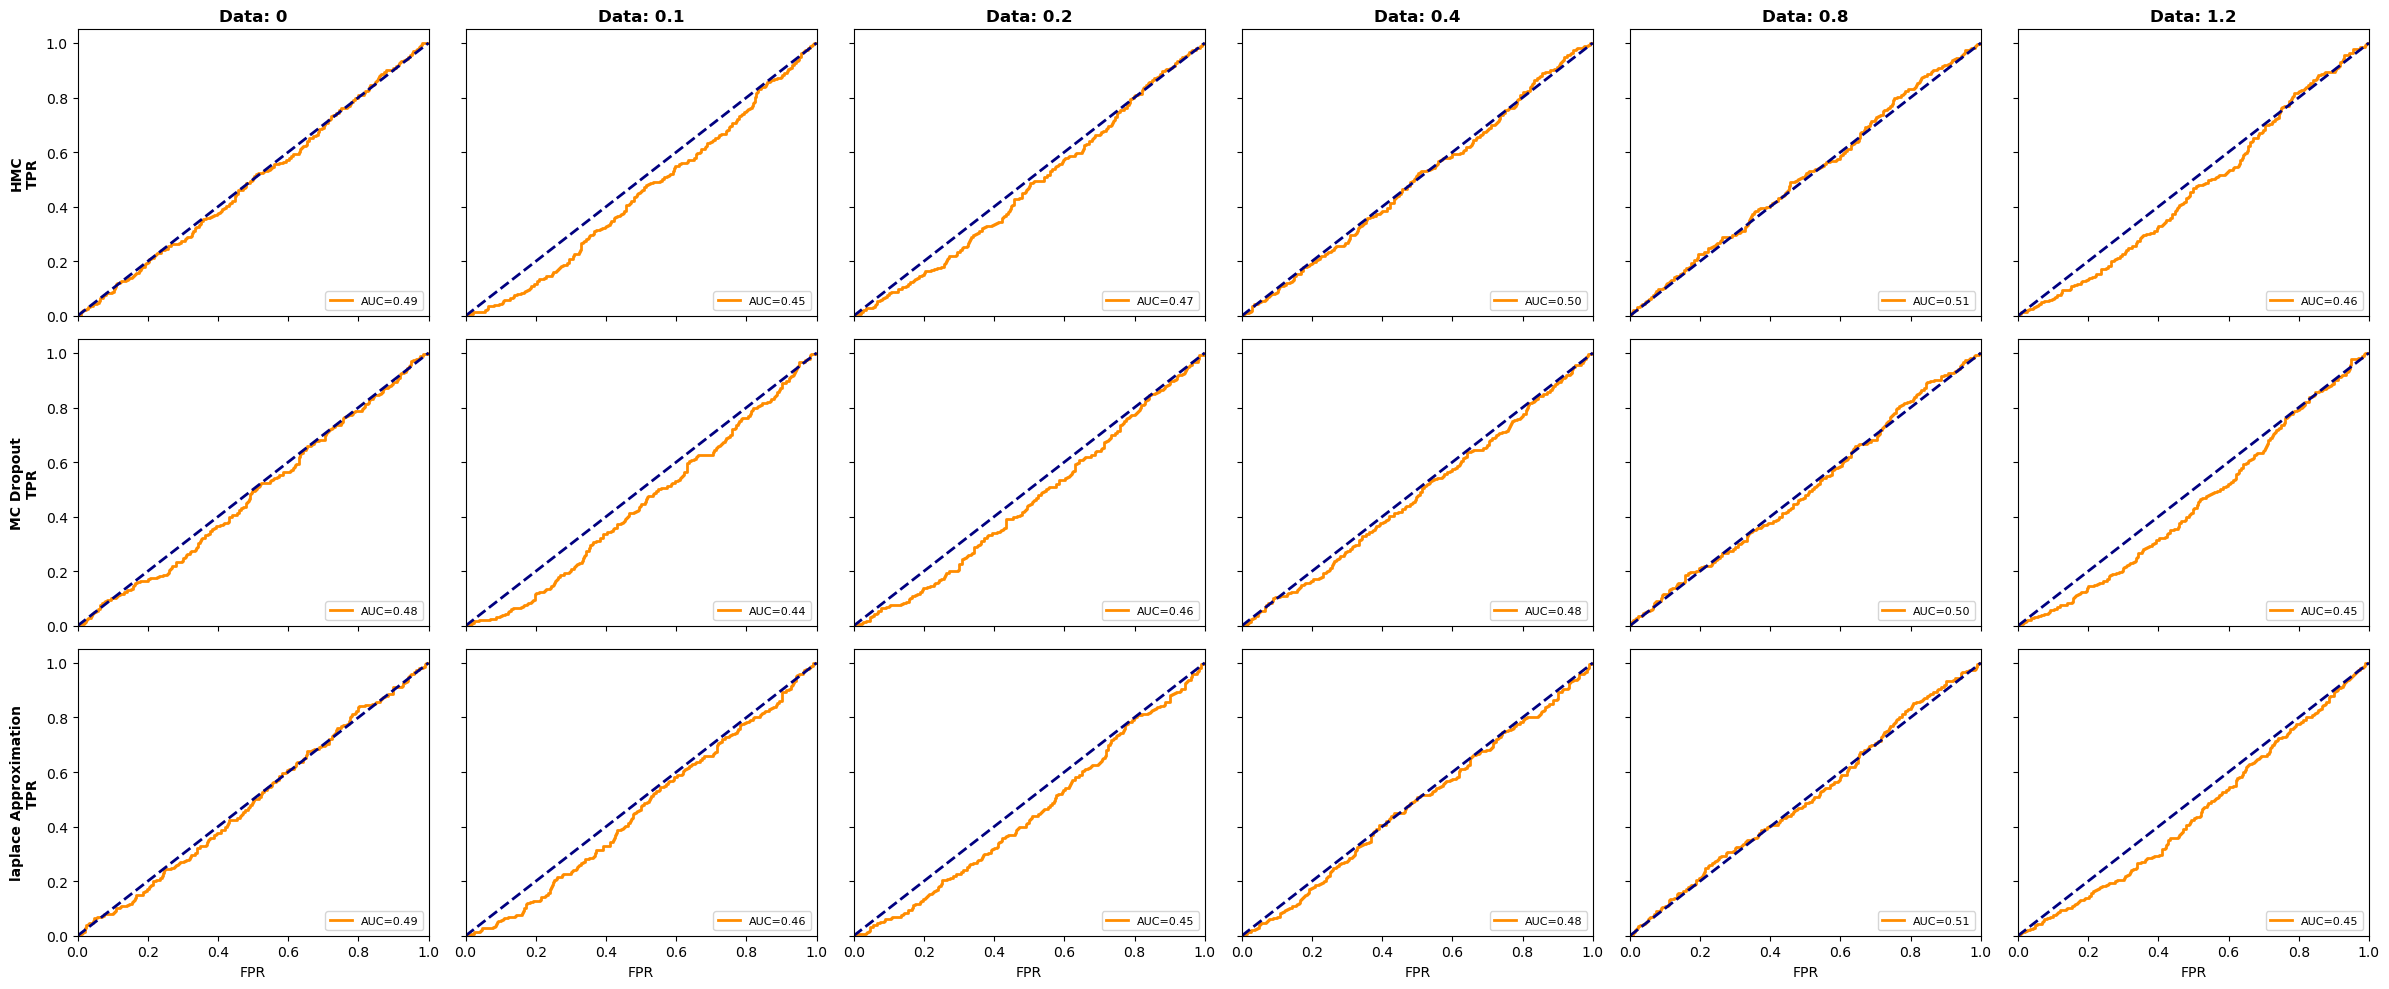

In [ ]:
# If robustness check fails, compare between new samples.
uq_methods_list = ['HMC', 'MC Dropout', 'laplace Approximation']
datatypes = [ '0.1', '0.2', '0.4', '0.8', '1.2', '-0.2']
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(24, 10), sharex=True, sharey=True)
for i, uqmethod in enumerate(uq_methods_list):     
    for j, dt in enumerate(datatypes):
        ax = axes[i, j]
        ood = np.concatenate((std_shifting[i,0,:], std_shifting[i][j+1]), axis = 0)
        ood = ood / np.max(ood)
        oods = np.concatenate((np.zeros(std_shifting[i][0].shape[0]), np.ones(std_shifting[i][j+1].shape[0])), axis = 0)
        auroc = roc_auc_score(oods, ood)
        fpr, tpr, _ = roc_curve(oods, ood)
        print(f"Method: {uqmethod}, Data: {dt} -> AUROC: {auroc:.4f}")
        ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC={auroc:.2f}')
        ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        if i == 0:
            ax.set_title(f"Data: {dt}", fontsize=12, fontweight='bold')
        if j == 0:
            ax.set_ylabel(f"{uqmethod}\nTPR", fontsize=10, fontweight='bold')
        else:
            ax.set_ylabel("")
        if i == 2:
            ax.set_xlabel('FPR')
        ax.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()

## Conformal Prediction

In [19]:
model = torch.load(model_save_file, weights_only=False)
model.to(device)
alpha = 0.1  # Target error rate (90% coverage)
n_cal = 500  # Number of samples for calibration

# Split remaining test data into calibration and final test
indices = np.arange(num_test)
np.random.shuffle(indices)
cal_idx = indices[:n_cal]
test_idx = indices[n_cal:]

# Get predictions for calibration set
x_branch_cal = test_data['X_train'][cal_idx]
x_trunk_cal = test_data['X_trunk']
y_cal = test_data['Y_train'][cal_idx]

with torch.no_grad():
    x_b = torch.from_numpy(x_branch_cal).float().to(device)
    x_t = torch.from_numpy(x_trunk_cal).float().to(device)
    y_cal_pred = model.predict(x_b, x_t).cpu().numpy()

# Calculate non-conformity scores (Absolute Residuals)
# For vector outputs, we use point-wise absolute error
scores = np.abs(y_cal - y_cal_pred)

# Compute the (1-alpha) quantile of the scores
q_level = np.ceil((n_cal + 1) * (1 - alpha)) / n_cal
qhat = np.quantile(scores, q_level, axis=0) # Point-wise quantile

print(f"Calibration complete using {n_cal} samples.")
print(f"Quantile (qhat) mean value: {qhat.mean():.4f}")

Calibration complete using 500 samples.
Quantile (qhat) mean value: 0.1674


Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 86.2%
ID Coverage: 89.1%
OOD Coverage: 82.6%
Average Prediction Interval Width: 0.3347
AUROC of 0 for OOD detection: 0.77985
Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 87.9%
ID Coverage: 89.1%
OOD Coverage: 86.4%
Average Prediction Interval Width: 0.3347
AUROC of 0.1 for OOD detection: 0.6619999999999999
Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 86.8%
ID Coverage: 89.1%
OOD Coverage: 84.0%
Average Prediction Interval Width: 0.3347
AUROC of 0.2 for OOD detection: 0.67817
Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 84.0%
ID Coverage: 89.1%
OOD Coverage: 77.6%
Average Prediction Interval Width: 0.3347
AUROC of 0.4 for OOD detection: 0.8518225
Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 82.7%
ID Coverage: 89.1%
OOD Coverage: 74.7%
Average Prediction Interval Width: 0.3347
AUROC of 0.8 for OOD det

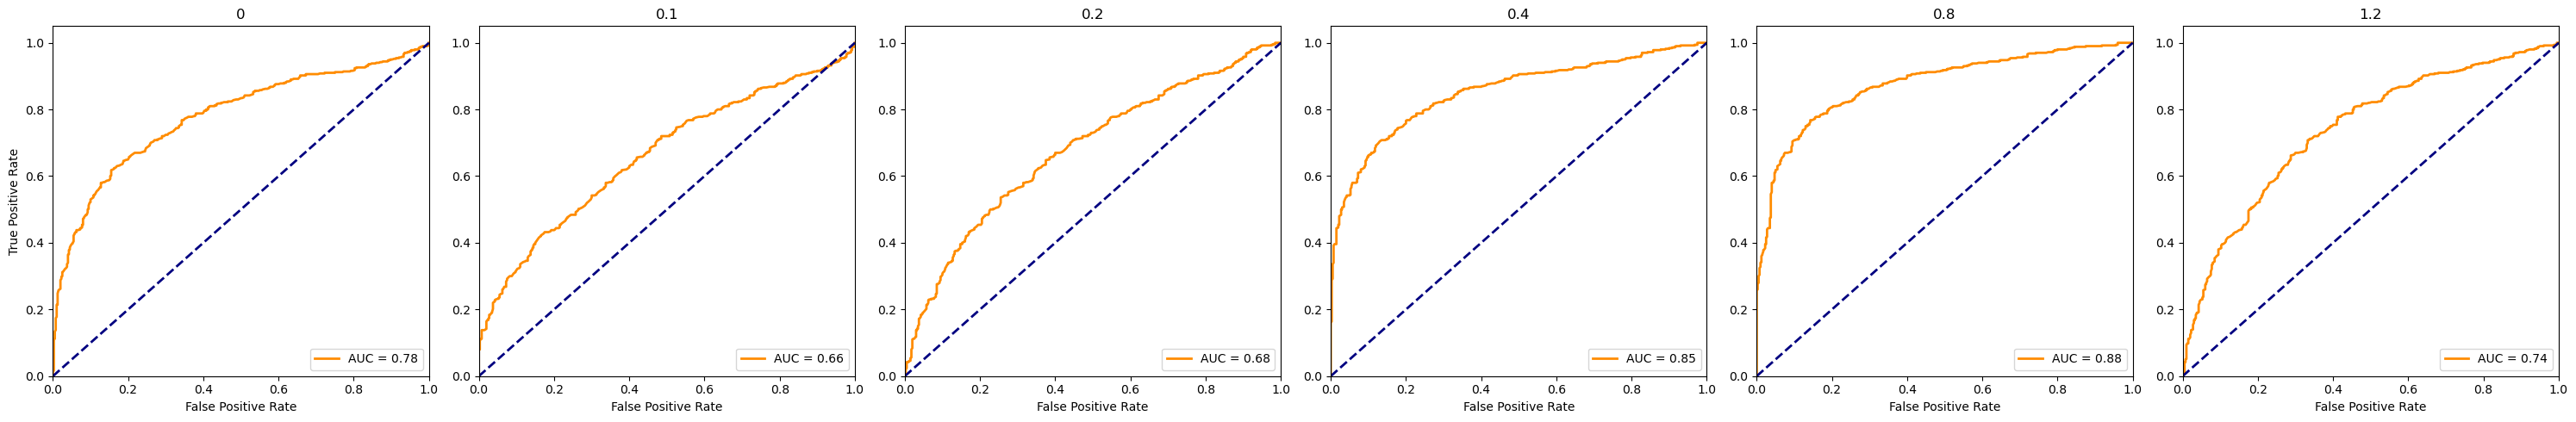

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(30, 5)) 
for i, datatype in enumerate(datatypes):
    
    ax = axes[i]
    # Evaluate on the remaining test set
    x_branch_final = np.concatenate((test_data['X_train'][test_idx], data_shifting_data[i+1]['X_train']), axis=0) 
    y_test_final = np.concatenate((test_data['Y_train'][test_idx], data_shifting_data[i+1]['Y_train']), axis=0) 

    with torch.no_grad():
        x_b_final = torch.from_numpy(x_branch_final).float().to(device)
        y_test_pred = model.predict(x_b_final, x_t).cpu().numpy()

    # Prediction Intervals: [pred - qhat, pred + qhat]
    lower_bound = y_test_pred - qhat
    upper_bound = y_test_pred + qhat

    # Calculate empirical coverage
    cover = ((y_test_final >= lower_bound) & (y_test_final <= upper_bound)).mean(axis=1)
    coverage = cover.mean()
    cover_id = cover[:len(test_idx)]
    cover_ood = cover[len(test_idx):]
    cover_id_mean = cover_id.mean() 
    cover_ood_mean = cover_ood.mean()

    print(f"Results for alpha = {alpha} (Target Coverage: {1-alpha:.1%})")
    print(f"Empirical Test Coverage: {coverage:.1%}")
    print(f"ID Coverage: {cover_id_mean:.1%}")
    print(f"OOD Coverage: {cover_ood_mean:.1%}")
    print(f"Average Prediction Interval Width: {(upper_bound - lower_bound).mean():.4f}")


    oods = np.concatenate((np.ones(len(test_idx)), np.zeros(len(x_branch_final)-len(test_idx))), axis=0)

    auroc = roc_auc_score(oods, cover)
    fpr, tpr, _ = roc_curve(oods, cover)
    
    print(f"AUROC of {datatype} for OOD detection: {auroc}")

    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auroc:.2f}')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
 
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_xlabel('False Positive Rate')

    if i == 0:
        ax.set_ylabel('True Positive Rate')
    
    ax.set_title(f'{datatype}')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()

In [21]:
# If robustness check fails, recalibrate using new samples.

model = torch.load(model_save_file, weights_only=False)
model.to(device)
alpha = 0.1  # Target error rate (90% coverage)
n_cal = 100  # Number of samples for calibration

# Split remaining test data into calibration and final test
indices = np.arange(num_test_shift)
np.random.shuffle(indices)
cal_idx = indices[:n_cal]
test_idx = indices[n_cal:]

# Get predictions for calibration set
x_branch_cal = data_shifting_data[0]['X_train'][cal_idx]
x_trunk_cal = data_shifting_data[0]['X_trunk']
y_cal = data_shifting_data[0]['Y_train'][cal_idx]

with torch.no_grad():
    x_b = torch.from_numpy(x_branch_cal).float().to(device)
    x_t = torch.from_numpy(x_trunk_cal).float().to(device)
    y_cal_pred = model.predict(x_b, x_t).cpu().numpy()

# Calculate non-conformity scores (Absolute Residuals)
# For vector outputs, we use point-wise absolute error
scores = np.abs(y_cal - y_cal_pred)

# Compute the (1-alpha) quantile of the scores
q_level = np.ceil((n_cal + 1) * (1 - alpha)) / n_cal
qhat = np.quantile(scores, q_level, axis=0) # Point-wise quantile

print(f"Calibration complete using {n_cal} samples.")
print(f"Quantile (qhat) mean value: {qhat.mean():.4f}")

Calibration complete using 100 samples.
Quantile (qhat) mean value: 0.1932


Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 88.9%
ID Coverage: 90.7%
OOD Coverage: 87.5%
Average Prediction Interval Width: 0.3864
AUROC of 0 for OOD detection: 0.6792666666666667
Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 90.9%
ID Coverage: 90.7%
OOD Coverage: 91.0%
Average Prediction Interval Width: 0.3864
AUROC of 0.1 for OOD detection: 0.511225
Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 89.5%
ID Coverage: 90.7%
OOD Coverage: 88.6%
Average Prediction Interval Width: 0.3864
AUROC of 0.2 for OOD detection: 0.5565666666666667
Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 86.4%
ID Coverage: 90.7%
OOD Coverage: 83.1%
Average Prediction Interval Width: 0.3864
AUROC of 0.4 for OOD detection: 0.7733333333333334
Results for alpha = 0.1 (Target Coverage: 90.0%)
Empirical Test Coverage: 84.9%
ID Coverage: 90.7%
OOD Coverage: 80.6%
Average Prediction Interval Width: 0.3864
AUR

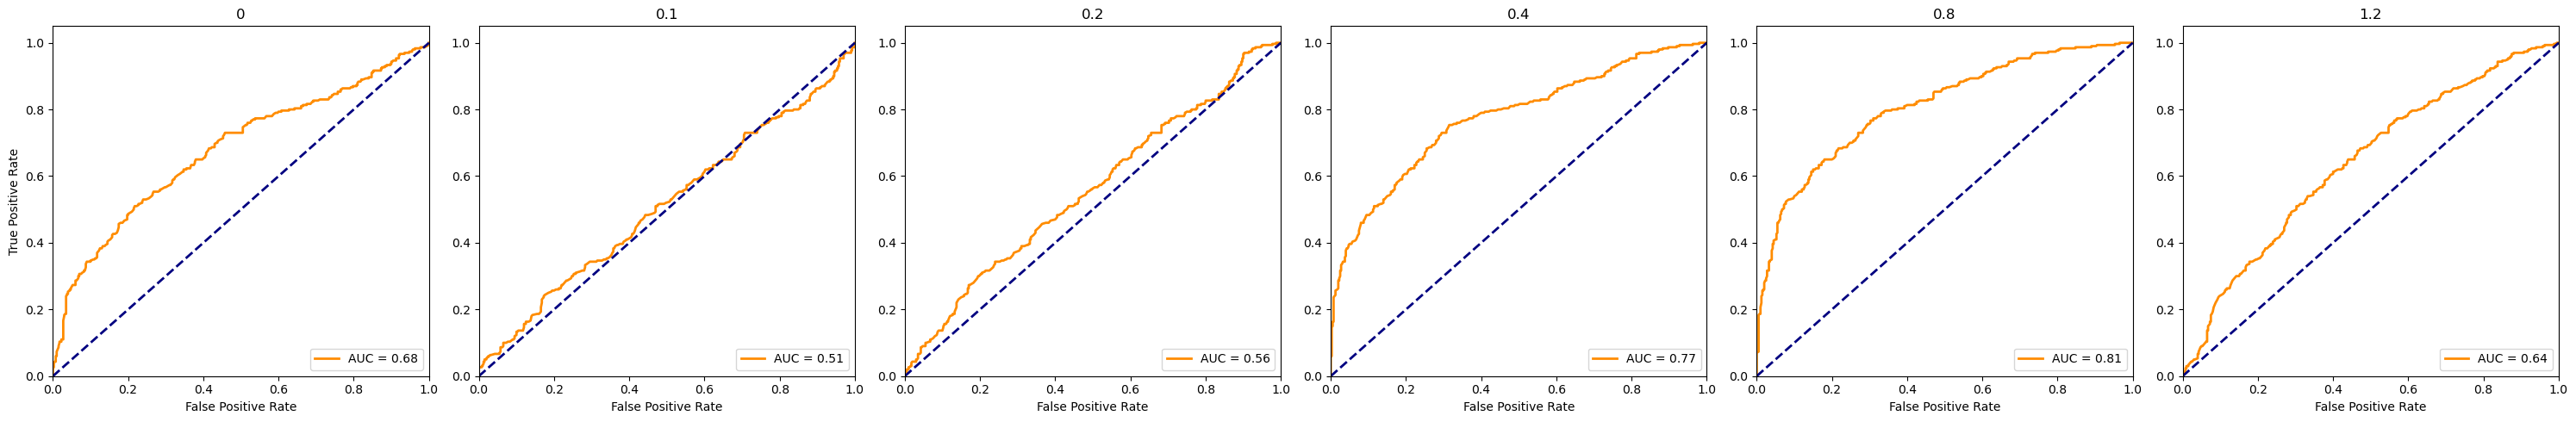

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(30, 5)) 
for i, datatype in enumerate(datatypes):
    
    ax = axes[i]
    # Evaluate on the remaining test set
    x_branch_final = np.concatenate((data_shifting_data[0]['X_train'][test_idx], data_shifting_data[i+1]['X_train']), axis=0) 
    y_test_final = np.concatenate((data_shifting_data[0]['Y_train'][test_idx], data_shifting_data[i+1]['Y_train']), axis=0) 

    with torch.no_grad():
        x_b_final = torch.from_numpy(x_branch_final).float().to(device)
        y_test_pred = model.predict(x_b_final, x_t).cpu().numpy()

    # Prediction Intervals: [pred - qhat, pred + qhat]
    lower_bound = y_test_pred - qhat
    upper_bound = y_test_pred + qhat

    # Calculate empirical coverage
    cover = ((y_test_final >= lower_bound) & (y_test_final <= upper_bound)).mean(axis=1)
    coverage = cover.mean()
    cover_id = cover[:len(test_idx)]
    cover_ood = cover[len(test_idx):]
    cover_id_mean = cover_id.mean() 
    cover_ood_mean = cover_ood.mean()

    print(f"Results for alpha = {alpha} (Target Coverage: {1-alpha:.1%})")
    print(f"Empirical Test Coverage: {coverage:.1%}")
    print(f"ID Coverage: {cover_id_mean:.1%}")
    print(f"OOD Coverage: {cover_ood_mean:.1%}")
    print(f"Average Prediction Interval Width: {(upper_bound - lower_bound).mean():.4f}")


    oods = np.concatenate((np.ones(len(test_idx)), np.zeros(len(x_branch_final)-len(test_idx))), axis=0)

    auroc = roc_auc_score(oods, cover)
    fpr, tpr, _ = roc_curve(oods, cover)
    
    print(f"AUROC of {datatype} for OOD detection: {auroc}")

    ax.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {auroc:.2f}')
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_xlabel('False Positive Rate')

    if i == 0:
        ax.set_ylabel('True Positive Rate')
    
    ax.set_title(f'{datatype}')
    ax.legend(loc='lower right')

plt.tight_layout()
plt.show()